In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle

import tifffile as tif

import xarray as xr
import os

from collections import defaultdict
from itertools import islice
import random

from skimage.feature import graycomatrix, graycoprops
from skimage import io, color, img_as_ubyte
from tqdm import tqdm

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import math

In [2]:
sar_dir = '/data/exjobb/sarssw/sar_multiprocess/'   
bouy_survey_dir = '../bouy_survey/1h_survey/result_df'
svc_dir = './out/homogenity_svc.pkl'

with open(svc_dir, 'rb') as f: svc = pickle.load(f)
with open(bouy_survey_dir,'rb') as f_r: bouy_survey_df = pickle.load(f_r)
    
bouy_survey_df['sar_name'] = bouy_survey_df['sar_url'].apply(lambda row: row.split('/')[-1].split('.')[0])
bouy_survey_df['bouy_name'] = bouy_survey_df['bouy_file_name'].apply(lambda row: row.split('.')[0])
bouy_survey_df = bouy_survey_df.set_index(['sar_name', 'bouy_name']).sort_index()

/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
# for getting the sigma0
def sar_gen(sar_dir, only_center = False, hom = True):
    sar_files = os.listdir(sar_dir)
    for file_name in sar_files:
        if not file_name.endswith('.tif'): continue
            
        if only_center:
            if not file_name.split('.')[0][-1] == '0': continue
                
        with tif.TiffFile(os.path.join(sar_dir, file_name)) as tif_img:
            #for v in tif_img.asarray():
            v = tif_img.asarray()[0,...]   
            #print(tif_img.shaped_metadata[0])
            if np.isnan(v).any(): continue

            ubyte = img_as_ubyte((v - v.min()) / (v.max() - v.min()))
            glcm = graycomatrix(ubyte, distances=[10], angles=[0], levels=256,
                                symmetric=True, normed=True)

            glcm_types =  ['homogeneity', 'dissimilarity', 'correlation']
            pred = svc.predict([[graycoprops(glcm, gt)[0, 0] for gt in glcm_types]])[0]
            if pred == (0 if hom else 1):
                yield v

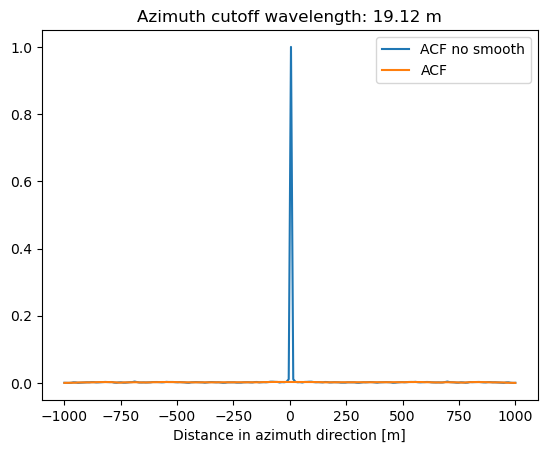

Azimuth cutoff wavelength: 19.12 m
0.5057333637761401


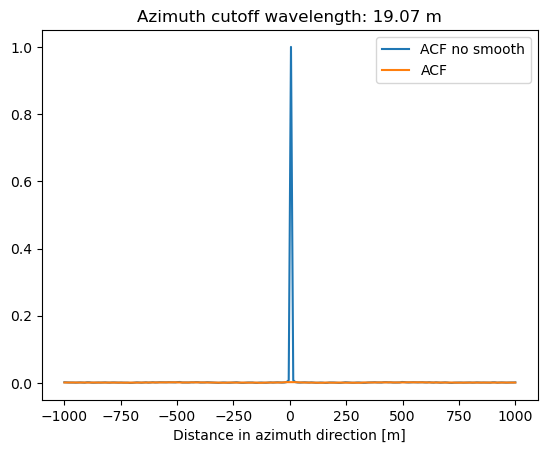

Azimuth cutoff wavelength: 19.07 m
0.5040540009520013


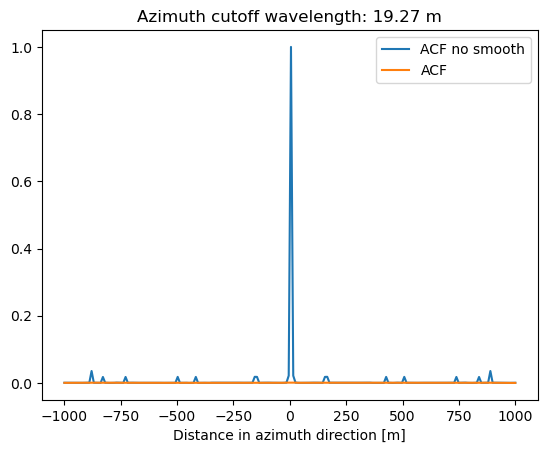

Azimuth cutoff wavelength: 19.27 m
0.5111315862355117


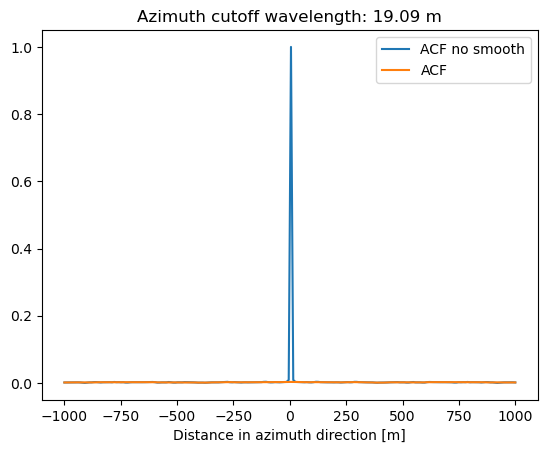

Azimuth cutoff wavelength: 19.09 m
0.5045670145302206


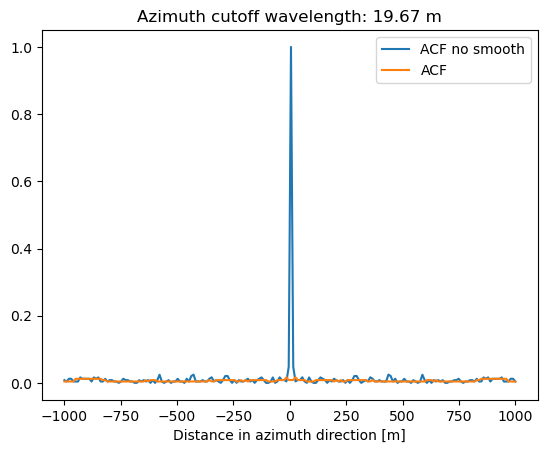

Azimuth cutoff wavelength: 19.67 m
0.5250994559374739


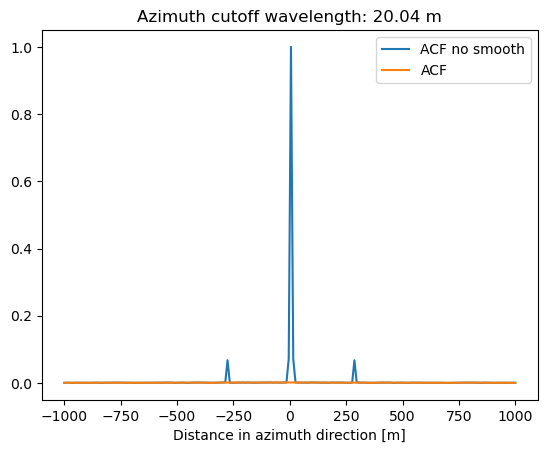

Azimuth cutoff wavelength: 20.04 m
0.5376608568982907


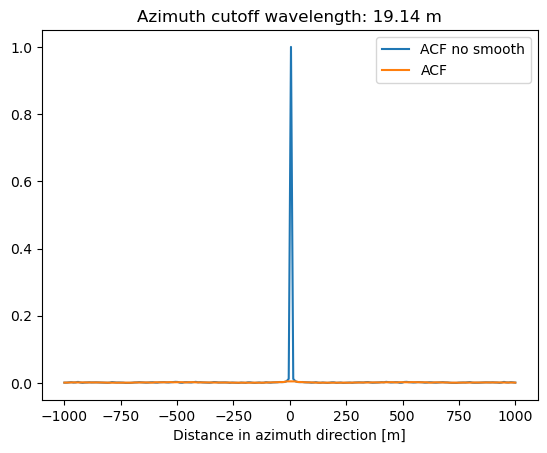

Azimuth cutoff wavelength: 19.14 m
0.5062851109734344


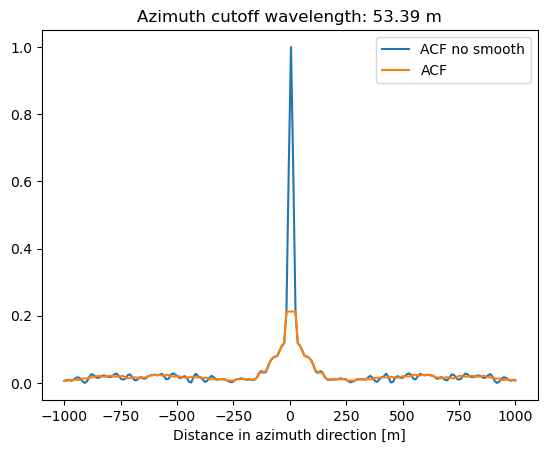

Azimuth cutoff wavelength: 53.39 m
0.9162728525463676


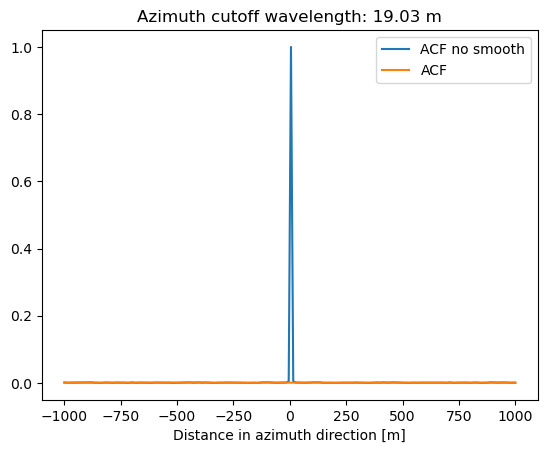

Azimuth cutoff wavelength: 19.03 m
0.502615151235422


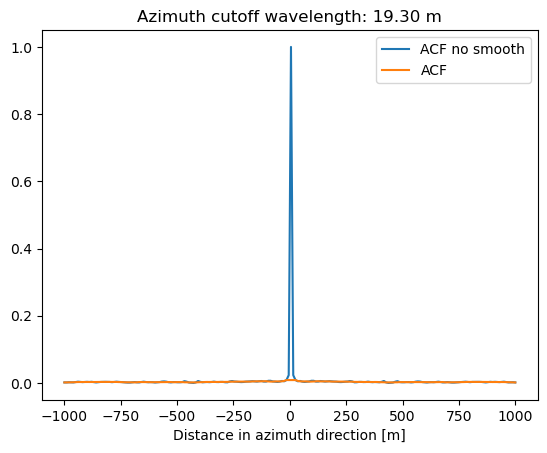

Azimuth cutoff wavelength: 19.30 m
0.5121239087275643


In [111]:
import numpy as np
from itertools import islice
import scipy.signal
import scipy.optimize

def gaussian(x, lambda_c, amplitude = 1):
    return amplitude * np.exp((-(np.pi ** 2)) * ((x ** 2) / (lambda_c ** 2)))

for sigma0 in islice(sar_gen(sar_dir), 5):
    # Calculate acf with wiener_khinchin:
    # the 2-D PSD is evaluated as the square modulus of the Fourier 
    # transform of the VV-polarized uncalibrated intensity image;
    #np.log10(np.where(sigma0>0.0, sigma0, 1e-300))
    psd = np.abs(np.fft.fft2(sigma0)) ** 2
    # The 1-D azimuth PSD, PSDx, is evaluated by averaging the PSD along the range direction;
    psdx = psd.mean(axis=1)
    # The AACF is obtained by applying the inverse Fourier transform:
    # AACF= 1/n^2 * IFFT(PSDx),
    acf = np.fft.ifft(psdx)
    acf = np.fft.fftshift(acf)
    acf = np.abs(acf)
    
    # Normalize 
    acf = (acf - acf.min()) / (acf.max() - acf.min())
    
    acf_no_smooth = acf
    # A smoothing 7 × 1 median filter is applied to the modulus of the 
    # azimuth autocorrelation function (AACF) in order to remove the 0-lag contribution.
    acf = scipy.signal.medfilt(acf, kernel_size=7)
    
    # meter conversion for the image, since we have a 2kmx2km subimage that is (200, 200)
    # we want from -1000m to 1000m and 200 samples
    x_data = np.linspace(-1000, 1000, 200)
    # Initial guess for Gaussian parameters
    initial_params = [500]

    # Fit the Gaussian function
    ps, _ = scipy.optimize.curve_fit(gaussian, x_data, acf_no_smooth, p0=initial_params, method='lm')
    lambda_c = ps[0]
    
    plt.plot(x_data, acf_no_smooth, label='ACF no smooth')
    plt.plot(x_data, acf, label='ACF')

    #plt.plot(x_data, gaussian(x_data, *ps), label='Fitted Gaussian', linestyle='--')
    plt.xlabel('Distance in azimuth direction [m]')
    plt.title(f'Azimuth cutoff wavelength: {lambda_c:.2f} m')
    plt.legend()
    plt.show()
    print(f'Azimuth cutoff wavelength: {lambda_c:.2f} m')
    print(max(gaussian(x_data, *ps)))

In [126]:
def gaussian(x, lambda_c, amplitude = 1):
    return amplitude * np.exp((-(np.pi ** 2)) * ((x ** 2) / (lambda_c ** 2)))
def get_acw_gaussian_fit(sigma0, *, median_filt=False, tune_amp = True, db = True, just_std=True):
    if db:
        sigma0 = np.log10(np.where(sigma0>0.0, sigma0, 1e-30))
    psd = np.abs(np.fft.fft2(sigma0)) ** 2
    psdx = psd.mean(axis=1)
    acf = np.fft.ifft(psdx)
    acf = np.fft.fftshift(acf)
    acf = np.abs(acf)

    
    acf = (acf - acf.min()) / (acf.max() - acf.min())
    if median_filt:
        acf = scipy.signal.medfilt(acf, kernel_size=7)
    if just_std:
        return acf.std()        
    
    x_data = np.linspace(-1000, 1000, 200)
    initial_params = [500, 1] if tune_amp else [500]
    try:
        ps, _ = scipy.optimize.curve_fit(gaussian, x_data, acf, p0=initial_params, method='lm')
        return ps[0]
    except RuntimeError:
        return None

In [187]:
def get_acw(sigma0, *, median_filt=False, db = True):
    if db: sigma0 = np.log10(np.where(sigma0>0.0, sigma0, 1e-30))
    
    psd = np.abs(np.fft.fft2(sigma0)) ** 2
    psdx = psd.mean(axis=1)
    acf = np.fft.ifft(psdx)
    acf = np.fft.fftshift(acf)
    acf = np.abs(acf)

    acf = (acf - acf.min()) / (acf.max() - acf.min())
    if median_filt:
        acf = scipy.signal.medfilt(acf, kernel_size=7)
        
    return acf.std()        


In [188]:
# todo change the names so that they dont use a dash as a separator
def unpack_name(name):
    sar_name, *bouy_name, ix = name.split('.')[0].split('-')
    return sar_name, '-'.join(bouy_name), ix

def get_value_old(name, variable_name = 'VHM0'):
    sar_name, bouy_name, _ = unpack_name(name)

    url_df = bouy_survey_df[bouy_survey_df.sar_url.str.contains(sar_name)]
    bouy_df = url_df[url_df.bouy_file_name.str.contains(bouy_name)]
    value = bouy_df[bouy_df.bouy_variable_name == variable_name].bouy_variable_value
    if len(value) == 1: return value.item()

def get_value(sar_name, bouy_name, variable_name = 'VHM0'):
    bouy_df = bouy_survey_df.loc[(sar_name, bouy_name)]
    value = bouy_df[bouy_df.bouy_variable_name == variable_name].bouy_variable_value
    if len(value) == 1: return value.item()

In [208]:
sar_files = os.listdir(sar_dir)

file_name = sar_files[1]
file_name

with tif.TiffFile(os.path.join(sar_dir, file_name)) as tif_img:
    print(tif_img.asarray().shape)
    for v in tif_img.asarray():
        print(v)

(2, 200, 200)
[[0.00663224 0.00793041 0.01277858 ... 0.02541428 0.00897747 0.01492747]
 [0.00896345 0.01079969 0.01624003 ... 0.03007113 0.01814315 0.02541452]
 [0.02940556 0.02480552 0.03122533 ... 0.02322216 0.02061129 0.0211223 ]
 ...
 [0.0311637  0.03560785 0.02699953 ... 0.02370017 0.02157728 0.01153249]
 [0.02419454 0.04387451 0.0317818  ... 0.01114102 0.01315293 0.00721735]
 [0.02101723 0.03827171 0.03055162 ... 0.01666813 0.01037596 0.00754516]]
[[-7.41433727e-04 -3.23021569e-04  1.46643166e-04 ...  2.30049418e-03
   1.03341403e-03  6.56654959e-04]
 [-1.72369955e-04 -1.72425768e-04  3.14321811e-04 ...  8.42008027e-04
  -3.36626573e-04 -2.85161983e-05]
 [-4.68712982e-04 -7.42061940e-04 -3.23644637e-04 ...  3.02388388e-04
  -1.00752106e-03 -1.44137912e-03]
 ...
 [ 2.49022532e-04 -5.33890512e-04  2.48918332e-04 ...  7.76087148e-04
  -2.51307017e-04 -6.88011786e-04]
 [ 7.86673731e-04  4.22241942e-04 -8.16919709e-05 ... -5.48378191e-04
   6.79184100e-05 -9.50935904e-04]
 [ 2.2409725

In [219]:
def full_feature_extraction(sar_dir, preliminary_values=False, n_images=None):
    feature_dict = defaultdict(list)
    sar_files = os.listdir(sar_dir)

    for file_name in tqdm(sar_files):
        if not file_name.endswith('.tif'): continue
        
        with tif.TiffFile(os.path.join(sar_dir, file_name)) as tif_img:
            metadata_dict, = tif_img.shaped_metadata
            
            if preliminary_values:
                value = get_value(metadata_dict['sar_name'], metadata_dict['bouy_name'])
                
            for v, pol in zip(tif_img.asarray(), metadata_dict['pol']):
                if np.isnan(v).any(): continue

                ubyte = img_as_ubyte((v - v.min()) / (v.max() - v.min()))
                glcm = graycomatrix(ubyte, distances=[10], angles=[0], levels=256,
                                    symmetric=True, normed=True)
                
                glcm_types =  ['homogeneity', 'dissimilarity', 'correlation']
                hom_test = svc.predict([[graycoprops(glcm, gt)[0, 0] for gt in glcm_types]])[0] == 0
                
                #filename and polarization for given image
                feature_dict['file_name'].append(file_name)
                feature_dict['pol'].append(pol)

                
                #bool for if image is homogenous or not
                feature_dict['hom_test'].append(hom_test)
                
                feature_dict['acw_median_db'].append(get_acw(v, median_filt=True, db=True))         
                feature_dict['acw_median'].append(get_acw(v, median_filt=True, db=False))
                feature_dict['acw_db'].append(get_acw(v, median_filt=False, db=True))
                feature_dict['acw'].append(get_acw(v, median_filt=False, db=False))
                
                if preliminary_values:
                    feature_dict['preliminary_value'].append(value)

    return pd.DataFrame(feature_dict)

In [220]:
feature_df = full_feature_extraction(sar_dir, preliminary_values=True, n_images=1000)
feature_df

100%|██████████| 31981/31981 [25:51<00:00, 20.61it/s]


,file_name,pol,hom_test,acw_median_db,acw_median,acw_db,acw,preliminary_value
0,S1B_IW_GRDH_1SDV_20211111T055808_20211111T0558...,VV,False,0.002919,0.087052,0.070373,0.122078,0.39
1,S1B_IW_GRDH_1SDV_20211111T055808_20211111T0558...,VH,False,0.006501,0.069869,0.077885,0.114314,0.39
2,S1A_IW_GRDH_1SDV_20211012T055839_20211012T0559...,VV,True,0.015859,0.031801,0.078497,0.094998,0.81
3,S1A_IW_GRDH_1SDV_20211012T055839_20211012T0559...,VH,True,0.009675,0.011724,0.078155,0.086765,0.81
4,S1B_IW_GRDH_1SDV_20210208T055759_20210208T0558...,VV,False,0.038821,0.043305,0.096263,0.099340,2.77
...,...,...,...,...,...,...,...,...
63957,S1A_IW_GRDH_1SDV_20211120T173328_20211120T1733...,VH,True,0.003635,0.004201,0.074682,0.080730,0.53
63958,S1B_IW_GRDH_1SDV_20211016T172458_20211016T1725...,VV,False,0.053687,0.078864,0.102707,0.118850,1.85
63959,S1B_IW_GRDH_1SDV_20211016T172458_20211016T1725...,VH,False,0.007307,0.109722,0.075099,0.136322,1.85
63960,S1B_IW_GRDH_1SDV_20210620T055803_20210620T0558...,VV,False,0.003508,0.045817,0.070588,0.098617,0.65


In [278]:
hom_df = feature_df[feature_df.hom_test]
display(hom_df[hom_df.pol == 'VV'].corr(numeric_only=True).preliminary_value)
display(hom_df[hom_df.pol == 'VH'].corr(numeric_only=True).preliminary_value)

hom_test                  NaN
acw_median_db        0.573101
acw_median           0.326177
acw_db               0.558298
acw                  0.272109
preliminary_value    1.000000
Name: preliminary_value, dtype: float64

hom_test                  NaN
acw_median_db        0.035990
acw_median           0.297298
acw_db              -0.122195
acw                  0.220169
preliminary_value    1.000000
Name: preliminary_value, dtype: float64

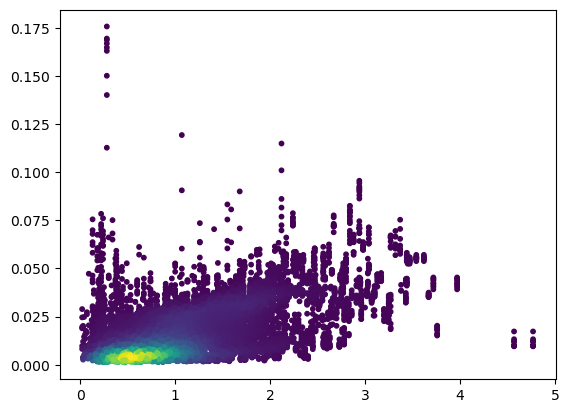

In [293]:
from scipy.stats import gaussian_kde
a = hom_df[hom_df.pol == 'VV']
a = a.dropna()
x = a.preliminary_value
y = a.acw_median_db

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=10)
plt.show()

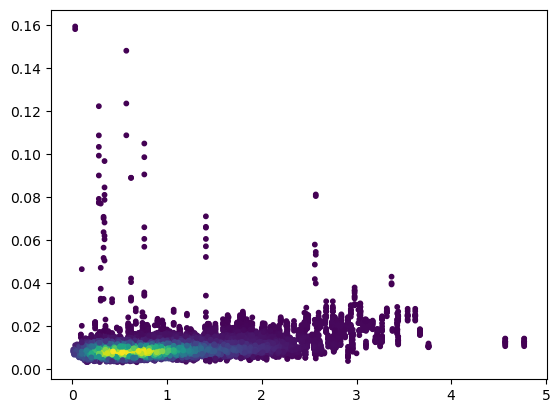

In [294]:
a = hom_df[hom_df.pol == 'VH']
a = a.dropna()
x = a.preliminary_value
y = a.acw_median

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=10)
plt.show()

In [232]:
def get_all_acw(sigma0):
    psd = np.abs(np.fft.fft2(sigma0)) ** 2
    psdx = psd.mean(axis=1)
    acf = np.fft.ifft(psdx)
    acf = np.fft.fftshift(acf)
    acf = np.abs(acf)

    acf = (acf - acf.min()) / (acf.max() - acf.min())
    acw = acf.std()
    acw_med = scipy.signal.medfilt(acf, kernel_size=7).std()
    
    sigma0_db = 10 * np.log10(np.where(sigma0>0.0, sigma0, 1e-30))
    psd = np.abs(np.fft.fft2(sigma0_db)) ** 2
    psdx = psd.mean(axis=1)
    acf = np.fft.ifft(psdx)
    acf = np.fft.fftshift(acf)
    acf = np.abs(acf)

    acf = (acf - acf.min()) / (acf.max() - acf.min())
    acw_db = acf.std()
    acw_med_db = scipy.signal.medfilt(acf, kernel_size=7).std()
    return acw, acw_med, acw_db, acw_med_db
           

In [230]:
def full_feature_extraction_fast(sar_dir, preliminary_values=False, n_images=None):
    feature_dict = defaultdict(list)
    sar_files = os.listdir(sar_dir)

    for file_name in tqdm(sar_files[:1000]):
        if not file_name.endswith('.tif'): continue
        
        with tif.TiffFile(os.path.join(sar_dir, file_name)) as tif_img:
            metadata_dict, = tif_img.shaped_metadata
            
            if preliminary_values:
                value = get_value(metadata_dict['sar_name'], metadata_dict['bouy_name'])
                
            for v, pol in zip(tif_img.asarray(), metadata_dict['pol']):
                if np.isnan(v).any(): continue

                ubyte = img_as_ubyte((v - v.min()) / (v.max() - v.min()))
                glcm = graycomatrix(ubyte, distances=[10], angles=[0], levels=256,
                                    symmetric=True, normed=True)
                
                glcm_types =  ['homogeneity', 'dissimilarity', 'correlation']
                hom_test = svc.predict([[graycoprops(glcm, gt)[0, 0] for gt in glcm_types]])[0] == 0
                
                #filename and polarization for given image
                feature_dict['file_name'].append(file_name)
                feature_dict['pol'].append(pol)

                
                #bool for if image is homogenous or not
                feature_dict['hom_test'].append(hom_test)
                
                acw, acw_med, acw_db, acw_med_db = get_all_acw(v)
                
                feature_dict['acw_median_db'].append(acw_med_db)         
                feature_dict['acw_median'].append(acw_med)
                feature_dict['acw_db'].append(acw_db)
                feature_dict['acw'].append(acw)
                
                if preliminary_values:
                    feature_dict['preliminary_value'].append(value)

    return pd.DataFrame(feature_dict)

In [233]:
feature_df_fast = full_feature_extraction_fast(sar_dir, preliminary_values=True, n_images=1000)

100%|██████████| 1000/1000 [00:18<00:00, 53.35it/s]


In [ ]:
hom_df = feature_df_fast[feature_df_fast.hom_test]
hom_df[hom_df.pol == 'VV'].corr().preliminary_value

In [277]:
hom_df = feature_df_fast[feature_df_fast.hom_test]
display(hom_df[hom_df.pol == 'VV'].corr(numeric_only=True).preliminary_value)
display(hom_df[hom_df.pol == 'VH'].corr(numeric_only=True).preliminary_value)

hom_test                  NaN
acw_median_db        0.605581
acw_median           0.412610
acw_db               0.584299
acw                  0.410392
preliminary_value    1.000000
Name: preliminary_value, dtype: float64

hom_test                  NaN
acw_median_db        0.046394
acw_median           0.298336
acw_db              -0.141249
acw                  0.197668
preliminary_value    1.000000
Name: preliminary_value, dtype: float64

In [239]:
sar_dir = '/data/exjobb/sarssw/sar_dataset/'   
all_sar_images = os.scandir(sar_dir)
test_file = os.path.join(sar_dir, next(fn for fn in all_sar_images if fn.is_file() and fn.name.endswith('.nc')))
xds =  xr.open_dataset(test_file)
xds

<xarray.Dataset>
Dimensions:    (line: 200, sample: 200, pol: 2)
Coordinates:
  * line       (line) int32 5713 5714 5715 5716 5717 ... 5909 5910 5911 5912
  * sample     (sample) int32 1293 1294 1295 1296 1297 ... 1489 1490 1491 1492
  * pol        (pol) object 'VV' 'VH'
Data variables:
    incidence  (line, sample) float64 ...
    velocity   (line) float64 ...
    sigma0     (pol, line, sample) float64 ...
Attributes: (12/13)
    safe:              S1A_IW_GRDH_1SDV_20210409T175650_20210409T175715_03737...
    swath:             IW
    platform:          SENTINEL-1A
    orbit_pass:        Ascending
    product:           GRDH
    platform_heading:  -14.52273487330976
    ...                ...
    bouy_name:         GL_TS_MO_6200078
    polarisations:     VV VH
    longitude:         -2.7819419430862444
    latitude:          47.244202016962895
    time:              2021-04-09T17:56:58.732717312
    subimage_index:    2

Quick test how to inclue incidence angle, and if to include velocity

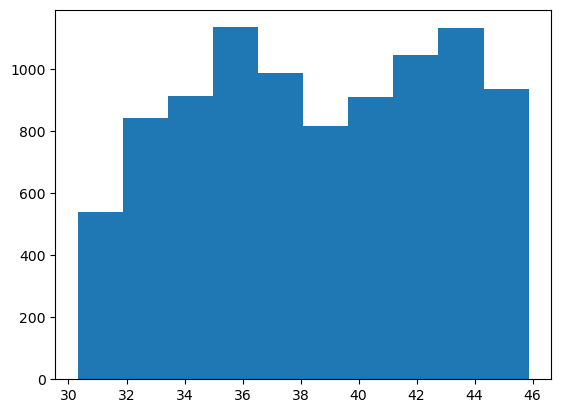

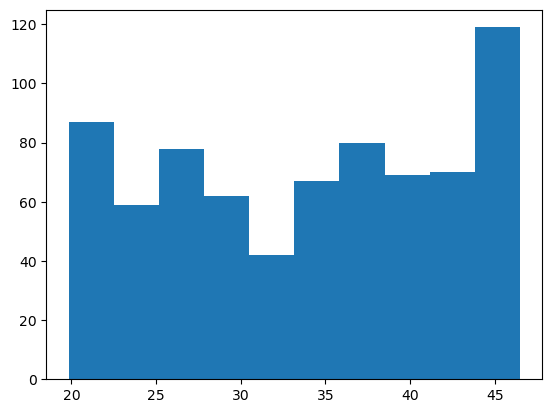

In [306]:
sar_dir = '/data/exjobb/sarssw/sar_dataset/'   
all_sar_images = os.scandir(sar_dir)
file_iter = (fn for fn in all_sar_images if fn.is_file() and fn.name.endswith('.nc'))
angles = []
for test_file in  islice(file_iter, 10000):
    xds = xr.open_dataset(os.path.join(sar_dir,test_file))
    l, s = xds.incidence.shape 
    angles.append((xds.swath, xds.incidence[l // 2, s // 2].item()))
plt.hist([a for s, a in angles if s == 'IW'])
plt.show()
plt.hist([a for s, a in angles if s == 'EW'])
plt.show()

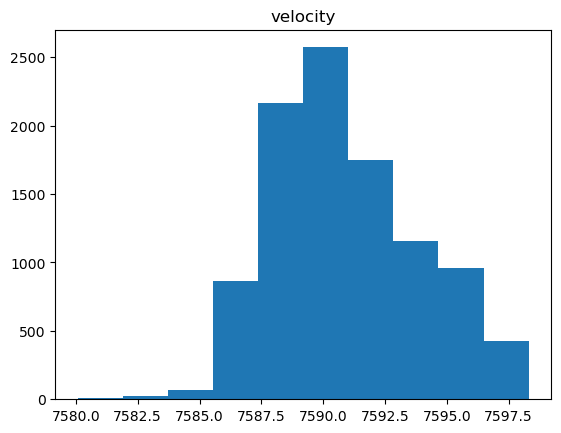

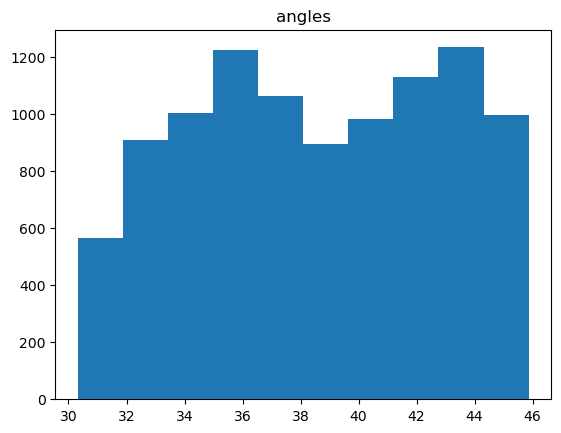

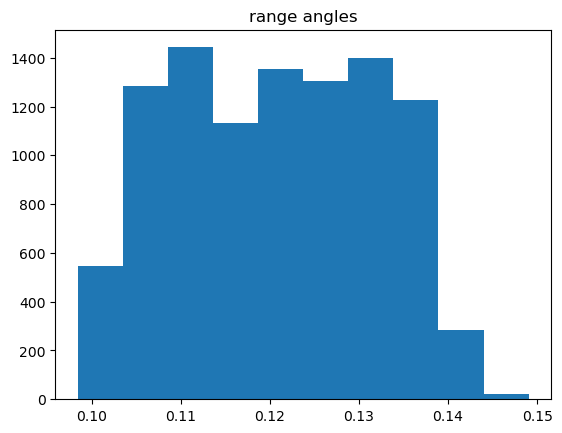

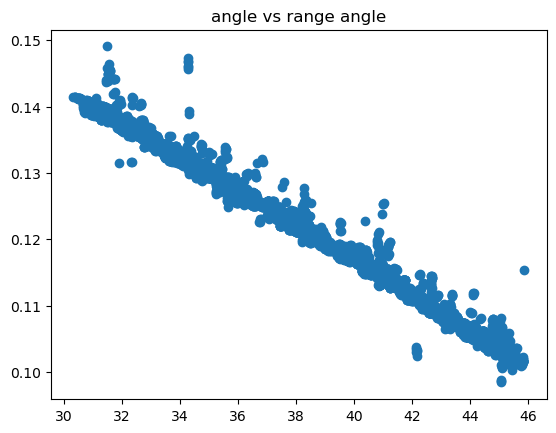

In [269]:
from itertools import islice
sar_dir = '/data/exjobb/sarssw/sar_dataset/'   
all_sar_images = os.scandir(sar_dir)
file_iter = (fn for fn in all_sar_images if fn.is_file() and fn.name.endswith('.nc'))
angles = []
range_a = []
vel = []
for test_file in  islice(file_iter, 1000):
    xds =  xr.open_dataset(os.path.join(sar_dir,test_file))
    l, s = xds.incidence.shape 
    angles.append(xds.incidence[l // 2, s // 2].item())
    range_a.append(xds.incidence.max() - xds.incidence.min())
    vel.append(xds.velocity[100].item())
plt.hist(vel)
plt.title('velocity')
plt.show()
plt.hist(angles)
plt.title('angles')
plt.show()
plt.hist(range_a)
plt.title('range angles')
plt.show()
plt.title('angle vs range angle')
plt.scatter(angles, range_a)
plt.show()

Conclusion:
velocity values are very similar, so dont include

its probably okay to only include center angle (angle most at bouy) because the angle range is very small, and also regular
if you think of physical interpretation of angle, this makes sense since the crops are same size